## WRF field edits 
for restart/continuation branch runs

In [148]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('/Users/bmapes/Box/vapor_games/WRF_RESTART_FILE/wrfrst_d03_2022-09-02_18:00:00')
ds

<xarray.Dataset>
Dimensions:                 (Time: 1, south_north: 180, west_east: 180,
                             bottom_top: 60, bottom_top_stag: 61,
                             soil_layers_stag: 5, dust_erosion_dimension: 3,
                             west_east_stag: 181, south_north_stag: 181,
                             land_cat_stag: 21, soil_cat_stag: 16,
                             ensemble_stag: 144, DIM0013: 7501, lagday: 150,
                             num_ext_model_couple_dom_stag: 1, seed_dim_stag: 2)
Coordinates:
    XLAT                    (Time, south_north, west_east) float32 ...
    XLONG                   (Time, south_north, west_east) float32 ...
    XTIME                   (Time) datetime64[ns] ...
    XLAT_U                  (Time, south_north, west_east_stag) float32 ...
    XLONG_U                 (Time, south_north, west_east_stag) float32 ...
    XLAT_V                  (Time, south_north_stag, west_east) float32 ...
    XLONG_V                 (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                dust_erosion_dimension, west_east_stag,
                                south_north_stag, land_cat_stag, soil_cat_stag,
                                ensemble_stag, DIM0013, lagday,
                                num_ext_model_couple_dom_stag, seed_dim_stag
Data variables: (12/525)
    Times                   (Time) |S19 ...
    LU_INDEX                (Time, south_north, west_east) float32 ...
    ZNU                     (Time, bottom_top) float32 ...
    ZNW                     (Time, bottom_top_stag) float32 ...
    ZS                      (Time, soil_layers_stag) float32 ...
    DZS                     (Time, soil_layers_stag) float32 ...
    ...                      ...
    PC_1                    (Time, south_north, west_east) float32 ...
    PC_2                    (Time, south_north, west_east) float32 ...
    LANDMASK                (Time, south_north, west_east) float32 ...
    LAKEMASK                (Time, south_north, west_east) float32 ...
    SST                     (Time, south_north, west_east) float32 ...
    SST_INPUT               (Time, south_north, west_east) float32 ...
Attributes: (12/193)
    TITLE:                             OUTPUT FROM WRF V4.3.3 MODEL
    START_DATE:                       2022-09-01_00:00:00
    SIMULATION_START_DATE:            2022-09-01_00:00:00
    FLAG_RESTART:                     1
    MAX_WRF_ALARMS:                   55
    WRF_ALARM_ISRINGING_01:           1
    ...                               ...
    ISLAKE:                           0
    ISICE:                            0
    ISURBAN:                          0
    ISOILWATER:                       0
    HYBRID_OPT:                       2
    ETAC:                             0.2

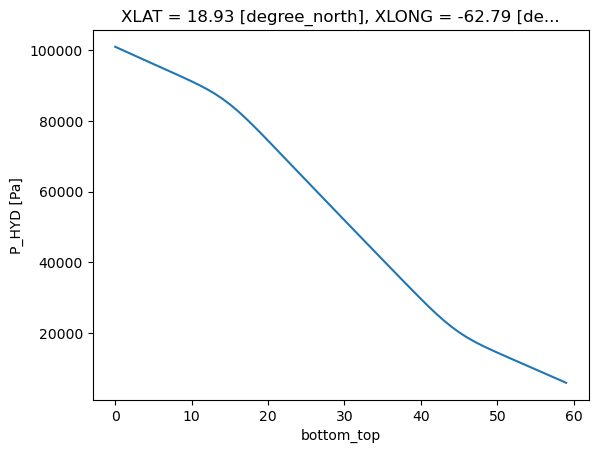

In [106]:
# see the levels 
ds.P_HYD[0,:,0,0].plot()

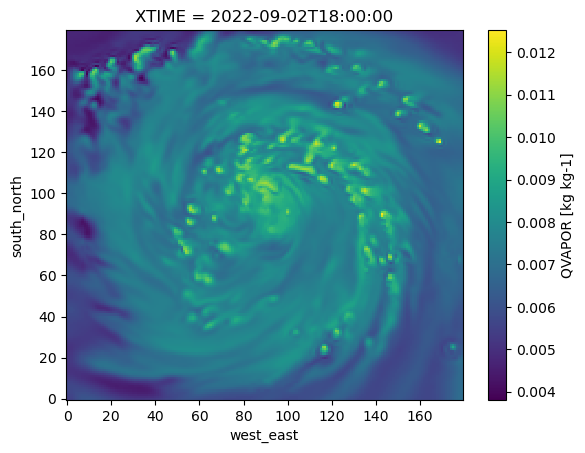

In [71]:
ds.QVAPOR[0][23].plot()

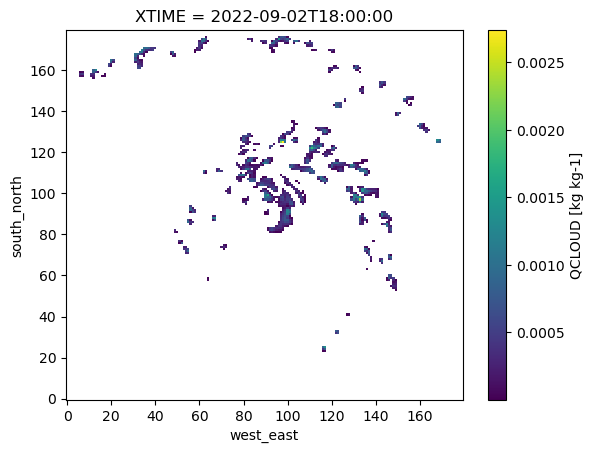

In [102]:
ds.QCLOUD.where(ds.QCLOUD >1e-7)[0,23].plot()

### Loop over levels, setting clear-air vapor to the level-mean clear-air vapor

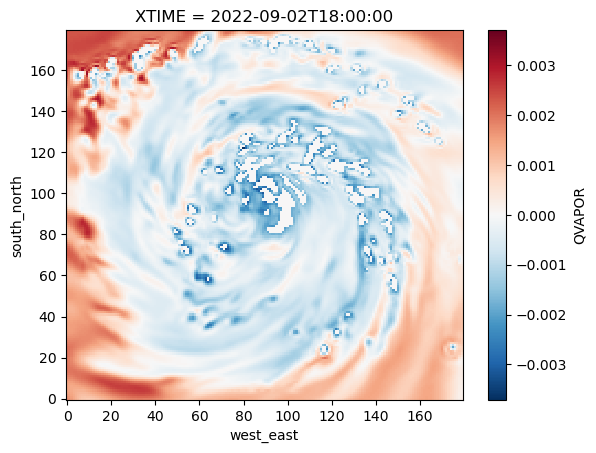

In [142]:
# Create a copy 
newQVAPOR = ds.QVAPOR.copy()

# Loop over levels, compute the eddy component (deviation from spatial mean, all for clear air only)
for ilev in range(ds.bottom_top.size):
    meanQV_clr = ds.QVAPOR[0,ilev,:,:].where(ds.QCLOUD[0,ilev,:,:] <1e-7).mean()
    eddy_clr = ds.QVAPOR[0,ilev,:,:] - meanQV_clr
    # print(ilev, meanQV_clr)

# add the diff, in a masked way only  
    newQVAPOR[0,ilev,:,:] -= eddy_clr *(ds.QCLOUD[0,ilev,:,:]<1e-7)

# Show the new-original increment at level 23 as a test 
(newQVAPOR[0,23,:,:] - ds.QVAPOR[0,23,:,:]).plot()

In [143]:
newQVAPOR.to_netcdf('/Users/bmapes/Box/vapor_games/WRF_RESTART_FILE/wrfrst_d03_2022-09-02_18:00:00_newQVAPOR.nc')

Text(0.5, 1.0, 'PW difference when clear-air is uniformized(mm)')

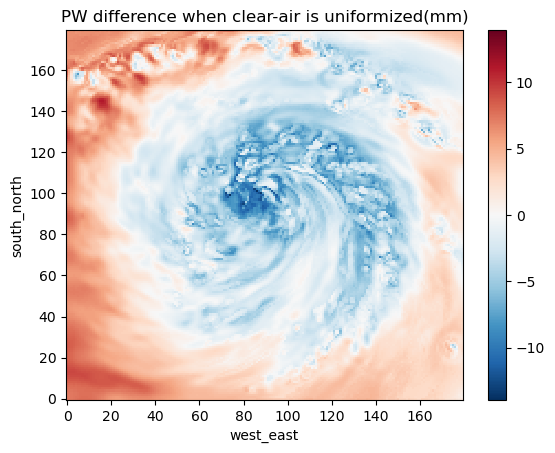

In [150]:
# ChaqtGPT wrote this initially 

# Extract the specific humidity variable (QVAPOR or Q2)
specific_humidity = ds.QVAPOR  # kg/kg
specific_humidity_clr = ds.QVAPOR.where(ds.QCLOUD <1e-7)  # kg/kg
specific_humidity_new = newQVAPOR # kg/kg

# Extract the air density variable (RHO or DENS)
air_density = ds.RHO  # kg/m3

# Extract the layer thickness variable (PH or PHB) meters from GPH units
layer_thickness = ds.PHP.differentiate(coord='bottom_top')/9.8   

# Vapor density 
vapor_density = specific_humidity * air_density * layer_thickness
vapor_density_clr = specific_humidity_clr * air_density * layer_thickness
vapor_density_new = specific_humidity_new * air_density * layer_thickness

# Calculate the mass-weighted column precipitable water
column_pw = vapor_density.sum(dim='bottom_top')  # Summing over the 'bottom_top' dimension
column_pw_clr = vapor_density_clr.sum(dim='bottom_top')  # Summing over the 'bottom_top' dimension
column_pw_new = vapor_density_new.sum(dim='bottom_top')  # Summing over the 'bottom_top' dimension

#plot diffs from domain mean of 56.07
(column_pw_new-column_pw).plot(); plt.title('PW difference when clear-air is uniformized(mm)')

# Temperatures are confusing, ignore for now

In [12]:
ds.T

<xarray.DataArray 'T' (Time: 1, bottom_top: 60, south_north: 180, west_east: 180)>
[1944000 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  perturbation potential temperature theta-t0
    units:        K
    stagger:

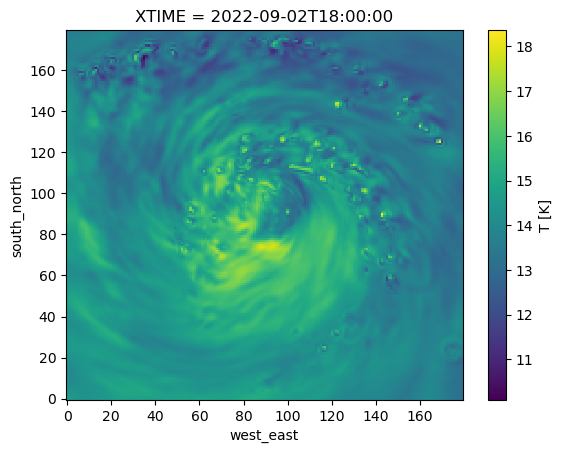

In [75]:
(ds.T)[0][23].plot()

Text(0.5, 1.0, 'THM_2-THM_1')

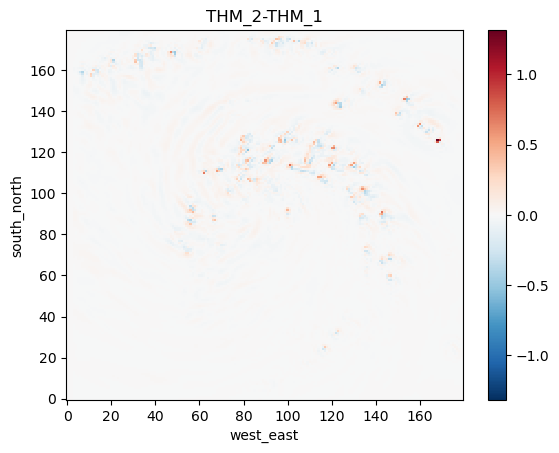

In [152]:
(ds.THM_2-ds.THM_1)[0][23].plot(); plt.title('THM_2-THM_1') # oh, it is two time levels 